### Prediction of cognitive level using Random Forest and NLP (Natural Language Processing) with Python, by Francisco Costela (May 2020)

This code uses the Alzheimer's project database.
There are four cognitive status cases (normal, impaired not MCI, MCI, dementia). I created a model with random forest to predict these four categories using a set of existing and fabricated parameters in the dataset. I performed feature selection to extract the parameters with higher correlations with cognitive levels for each description. In the end, the ones that worked the best in the prediction model were these four:
    

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    - Matches with the top words (N=28) for that clip


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    - Number of words not mentioned in any of the descriptions for that clip


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    - Length of the description


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    - Averaged speech rate
    
   

Comparative with other studies :
- Konig et al. (2015) got accuracy ~80% with support vector machines with verbal tasks including a picture description
- Hernandez et al. (2018) got max accuracy ~85% with support vector machines and random forests using the task of Cookie theft picture description
- Fraser et al. (2018) got max accuracy of 87% with logistic regressions also using the task of Cookie theft picture description
- Al-Hameed et al. (2016) got 94% accuracy with Bayes networks using the task of Cookie theft picture description

In [583]:
# First, importing all the required libraries and opening the dataset
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import spacy
#nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
import operator
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from itertools import cycle
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import tensorflow as tf
from plotly import graph_objs as go
from plotly import offline as py
from plotly import tools as tls
import colorlover as cl 
import numpy as np
from wordcloud import WordCloud
from mord import LogisticAT 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings('ignore')

Function to remove stop words and apply to the whole dataset. 

In [394]:
def text_process(mytext):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mytext if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


Testing the use of synonyms functions from wordnet

In [400]:
synonyms = []
for syn in wordnet.synsets("conundrum"):  
    for l in syn.lemmas(): 
        synonyms.append(l.name())

print (set(synonyms))

{'conundrum', 'brain-teaser', 'riddle', 'enigma'}


Loading the normative dataset first and applying the removal of stop words and the extraction of nouns and verbs. Using the NLP module from spacy it identifies tokens by categories and returns the reduced lemma for nouns and verbs (i.e. singular for nouns and infinitive for verbs) which facilitates matching.

Adverbs and adjectives were removed from the analysis. They did not contribute to increase the correlation of the new metric based on the number of matches.

In [416]:
nlp = spacy.load("en_core_web_sm")
normative = pd.read_excel('/Users/FranciscoCostela/Desktop/Alzheimer/normativedata.xlsx')
# remove nonstop words
normative['text'].apply(text_process)
normative['TextNounVerb'] = ""
normative['TextNounVerbPlain'] = ""

for s in normative.index: 
    nouns = [token.lemma_ for token in nlp(normative['text'][s]) if token.pos_ == "NOUN"]
    verbs = [token.lemma_ for token in nlp(normative['text'][s]) if token.pos_ == "VERB"]    
    normative['TextNounVerb'][s] =set(verbs+nouns+adjs)
    normative['TextNounVerbPlain'][s] = " ".join(normative['TextNounVerb'][s]) 
 

Next, I am going to iterate through the whole dataset and create a dictionary of words (only nouns and verbs) used for each clip. This dictionary of words will be useful later to fabricate the list of top words for each clip. This list will be used to calculate the matching parameter and also the non-matching parameter

Print the dictionary for clip number 13 (animation clip)

In [417]:
# Create the dictionary with the normative dataset (only nouns and verbs)
clipDictionary = {}
uniqueclips = np.unique(messages['clipid'])

for s in normative.index:    
    clip = normative['id'][s]   
    if clip in uniqueclips:
        mytext = list(normative['TextNounVerb'][s])        
        if clip not in clipDictionary:       
            clipDictionary[clip] = mytext          
        else:
            clipDictionary[clip] = mytext+clipDictionary[clip]
            
print(clipDictionary[13])

['arm', 'mustache', 'animate', 'acrobatic', 'clip', 'yellow', 'feature', 'look', 'hand', 'blue', 'green', 'deck', 'split', 'dress', 'leg', 'rail', 'talk', 'stand', 'several', 'spider', 'circular', 'balcony', 'woman', 'do', 'hair', 'black', 'man', 'green', 'animation', 'appear', 'exercise', 'several', 'yellow', 'girl', 'circular', 'balcony', 'do', 'talk', 'clay', 'black', 'man', 'arm', 'belly', 'black', 'animate', 'porch', 'yellow', 'balance', 'look', 'green', 'guy', 'shirt', 'leg', 'railing', 'girl', 'several', 'stand', 'circular', 'hair', 'do', 'stunt', 'man', 'animation', 'make', 'hop', 'arm', 'body', 'wood', 'limb', 'generate', 'shape', 'stop', 'balance', 'yellow', 'head', 'color', 'movie', 'hand', 'green', 'computer', 'shirt', 'house', 'wear', 'skin', 'tank', 'rail', 'tint', 'talk', 'several', 'resemble', 'appear', 'circular', 'balcony', 'woman', 'cone', 'hair', 'clay', 'sweater', 'black', 'man', 'arm', 'moustache', 'handstand', 'speak', 'middle', 'leap', 'yellow', 'jump', 'medal',

Load the 'Alzheimer' database. Fix variable cog status so values are within 0 to 4

In [418]:
messages = pd.read_excel('/Users/FranciscoCostela/Desktop/Alzheimer/AllAlzheimerData.xls')
messages['cog_status'] -=1

Apply the same stopword removal process and the tokenization (only verbs and nouns) to the texts. 

Print the original message and the resulting nouns and verbs that were created for the matching analysis

In [419]:
messages['FinalFixedText'].apply(text_process)
messages['TextNounVerb'] = ""
messages['TextNounVerbPlain'] = ""
messages['uniqueNumberWords'] = ""

for s in messages.index: 
    nouns = [token.lemma_ for token in nlp(messages['FinalFixedText'][s]) if token.pos_ == "NOUN"]
    verbs = [token.lemma_ for token in nlp(messages['FinalFixedText'][s]) if token.pos_ == "VERB"]   
    messages['TextNounVerb'][s] =set(verbs+nouns+adjs)
    messages['TextNounVerbPlain'][s] = " ".join(messages['TextNounVerb'][s])
    messages['uniqueNumberWords'][s] = len(messages['TextNounVerb'][s])

print(nlp(messages['FinalFixedText'][s]))    
print(set(nouns))
print(set(verbs))

Well there are three children that are a little dirty it looked like they lived on a farm and it looked like it was during the depression in the thirties and this car comes up with a chauffer so you know the person in the backseat is probably quite wealthy and i'm making an assumption that perhaps it's a grandparent that's coming to see them and it just shows you the difference between poverty and being wealthy, no i don't think so
{'assumption', 'farm', 'chauffer', 'child', 'car', 'depression', 'person', 'difference', 'poverty', 'grandparent', 'thirty', 'backseat'}
{'come', 'make', 'look', 'live', 'think', 'see', 'show', 'know'}


### Defining a new matching parameter (instead of the IA score)
The idea of the new matching parameter is to count only matches with nouns and verbs that belong to the top N for that clip. We do not want to count matches with a word that was not mentioned enough. But how do we define what is the number of the top? top10? top20? I applied an elbow method analysis using the correlation coefficient between cognitive level and the number of matches using tops of different sizes, from 5 to 50

In [580]:
# Testing number of top words
results = []

# Iterating from 5 to 35
for topnumber in range(5,50):
    mytop = {}
    
    # For each clip in the dictionary
    for c in clipDictionary:
        count = {}
        mytop[c] = []
        
        # For each word in the dictionary of that clip
        for word in clipDictionary[c]:
            
            # Create a new dictionary with the instances (counts) of words
            if word not in count:
                count[word] = 1
            else:
                count[word] +=1

        sort_orders = sorted(count.items(), key=lambda x: x[1], reverse=True)
        k = 0
        # Add to the top list the most popular words
        for i in sort_orders:
            if k < topnumber:
                mytop[c].append(i[0])  
                k +=1
            else:
                break
    
    messages['count']= 0   

    for s in messages.index:    
        clip = messages['clipid'][s]   
        count = 0        
        copytop = {}
        copytopNo = {}
        for citem in mytop[clip]:
            copytop[citem]=0      
        mytext = set(messages['TextNounVerb'][s]) # str(messages['TextNounVerb'][s]).strip()
        for i in mytext:

            if i in mytop[clip] and copytop[i]==0:             
                count +=1
                copytop[i] +=1
              
            else:
                synonyms = []
                for syn in wordnet.synsets(i):  
                    for l in syn.lemmas():                     
                        synonyms.append(l.name())
                mysyns = set(synonyms)
                for syn in mysyns:
                    if syn in mytop[clip]:
                        if copytop[syn]==0:
                            count +=1 
                            copytop[syn] +=1                              
                            break               

            messages['count'][s] = count   
            
    Y = messages['cog_status']
    features = ['count']

    R = dict([(key,0) for key in features])
    P = dict([(key,0) for key in features])

    for key in features:
        r, p = stats.pointbiserialr(messages[key], Y)
        R[key] = r
        P[key] = p
    
    # get absolute value of the correlations and sort    
    R_abs = dict([(key, abs(item)) for key, item in R.items()]) 
    R_sort = list(zip(*sorted(R.items(), key=operator.itemgetter(1), reverse=True)))
    R_sort_abs = list(zip(*sorted(R_abs.items(), key=operator.itemgetter(1), reverse=True)))
    results.append(abs(r))


Elbow method to determine the best top number and plot values (using go fucntion from Plotly so plot is interactive)

In [581]:
myrange = range(5,50)
print('Max correlation value is ', max(results), ' for ', myrange[results.index(max(results))], ' words')

x = np.arange(5,50)

fig = go.Figure(data=go.Scatter(x=x, y=results, mode="markers+lines"))
fig.show()

Max correlation value is  0.4164091676120827  for  28  words


Creating the top list with N=28 and printing for clip 13. This list of words is very descriptive. 

In [602]:
topnumber = 28
mytop = {}
for c in clipDictionary:
    count = {}
    mytop[c] = []
    for word in clipDictionary[c]:
        if word not in count:
            count[word] = 1
        else:
            count[word] +=1
    
    sort_orders = sorted(count.items(), key=lambda x: x[1], reverse=True)
    k = 0
    
    for i in sort_orders:
        
        if k < topnumber:
            mytop[c].append(i[0])  
            k +=1
        else:
            break

# printing the top 28 for words belonging to clip 13 in descending order, with most popular words first
print(mytop[13])


['yellow', 'green', 'several', 'circular', 'black', 'man', 'girl', 'talk', 'hair', 'leg', 'arm', 'balcony', 'wear', 'belly', 'do', 'house', 'mustache', 'animate', 'rail', 'look', 'stand', 'railing', 'jump', 'hand', 'balance', 'shirt', 'top', 'woman']


Clip 13 is actually an animation clip showing a character with moustache jumping and standing on top of a balcony rail and talking to a girl, so I inmediately thought of that clip just by reading the top words.

Below plotting a wordcloud with the top 100 words from clip 13, just for fun

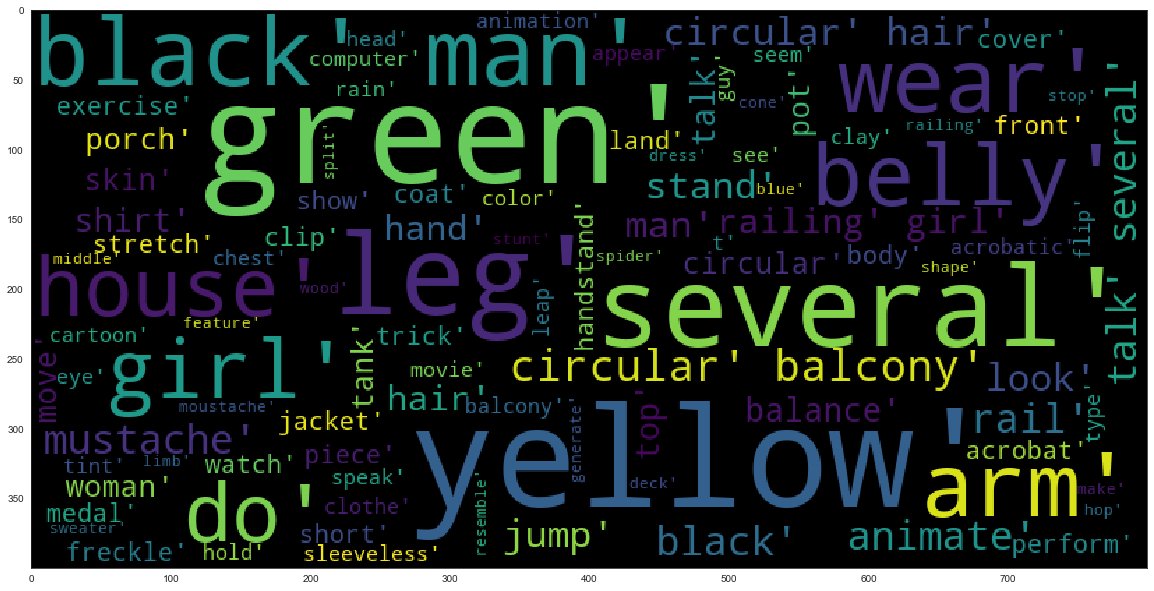

In [601]:
wordcloud = WordCloud(background_color='black',
                max_words = 100, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(20, 12))
wordcloud.generate(str(clipDictionary[13]))
plt.imshow(wordcloud);

Besides the new matching parameter, I am going to add three other variables to the model. The four variables are:

- **Matches with the top words (N=28) for that clip** (already explained) - This is the variable 'count' in the code

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; This is my new matching metric. I think it provides a better value than the IA score that takes into account all words (including adverbs and adjectives).


- **Number of words not mentioned in any of the descriptions for that clip** - Variable 'countneg' in the code

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I also included counts of words from the response that are not included in any of the responses for that given clip. My thinking here is that if you mention the word ‘spoon’ in a clip about penguins, there is something wrong with your cognitive processing, so I am also weighting on the non-matched words.

- **Length of the description** - Variable 'lentext' in the code

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There is clearly an effect of length of responses with the cognitive group - shorter descriptions associated with increased cognitive impairments. I tried to use this parameter to classify the groups before unsuccessfully but included it again in this model. I also compared it to number of words or number of unique words and all of them returned similar stats, being this one the one with slightly better correlation coefficients

- **Averaged speech rate** - Variable 'SpeechRateAvg' in the code

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This is the addition from Steph's dataset and it has clearly an impact. Cognitive impairments decrease the speech rate

The new metric combines these four variables and returns a value between 0 and 1. This is different than IA scores that had no range. To do this, I am converting each variable to a value within the 0-1 interval and then weighting the importance of each parameter according to their correlation coefficients with cognitive level.

After calculating the correlations, I determined the importance of each paramter. In the end, the new matching parameter has the largest correlation coefficient so it provides 35% of the final metric, followed by the length and the speech rate with 30%. The count of negative matches (words that are not in the dictionary for that clip) is just 5%

In [568]:
messages['newmetric']=0.0
messages['countneg']= 0
messages['count']= 0
messages['lentext']= 0
messages['countnegprob']= 0.0
messages['countprob']= 0.0
messages['lentextprob']= 0.0
messages['speechprob']= 0.0
messages['efficientprob']=0.0

# I adjust the weights based on their correlation coefficients
alpha = 0.3 # 0.7 # count
beta = 0.3 # 0.2 # length
gamma = 0.3 # speech rate
delta = 0.1 # count neg
#eta = 0.2

maxlen = messages['numchar'].max()
maxrate = messages['SpeechRateAvg'].max()
maxlen = messages['uniqueNumberWords'].max()

for s in messages.index:    
    clip = messages['clipid'][s]   
    count = 0
    countneg = 0
    copytop = {}
    copytopNo = {}
    for citem in mytop[clip]:
        copytop[citem]=0
    
    mytext = set(messages['TextNounVerb'][s]) # str(messages['TextNounVerb'][s]).strip()
    mywordcounts = messages['uniqueNumberWords'][s]
    
    myspeech = messages['SpeechRateAvg'][s]
                                                  
  
    for i in mytext:
        
        # create the count of matches with the top
        if i in mytop[clip] and copytop[i]==0:             
            count +=1
            copytop[i] +=1
           
        else:
            # take into account synonyms
            synonyms = []

            for syn in wordnet.synsets(i):  
                for l in syn.lemmas():                     
                    synonyms.append(l.name())

            mysyns = set(synonyms)
            for syn in mysyns:
                if syn in mytop[clip]:

                    if copytop[syn]==0:
                        count +=1 
                        copytop[syn] +=1
                         
                        break
              
            # for words or their synonyms that are not mentioned for that clip, increase the negative counter
            if i not in clipDictionary[clip]: 
                countneg +=1 
                for syn in mysyns:                    
                    if syn in clipDictionary[clip]:                        
                        countneg -=1
                        break
                
        messages['count'][s] = count   
        messages['countneg'][s] = countneg        
        messages['lentext'][s] = len(mytext)
        
        messages['countprob'][s]= float(alpha*(count/topnumber))
        messages['countnegprob'][s]= float(delta* (1- min(topnumber,countneg)/topnumber))
        messages['lentextprob'][s]= float(beta*mywordcounts/maxlen)
        messages['speechprob'][s]= float(gamma*myspeech/maxrate)
        #messages['efficientprob'][s] = float(eta*messages['contentefficiency'][s]/messages['contentefficiency'].max())
        
        # newmetric is the sum of the other four totalinng up to 1
        messages['newmetric'][s] =  float(messages['countprob'][s] + messages['speechprob'][s] + messages['lentextprob'][s] + messages['countnegprob'][s] + messages['efficientprob'][s])
        


Next, I will plot correlation coefficients and compare with IA scores. The new metric is slightly better. 

In [569]:
# correlate each one with the cognitive level
Y = messages['cog_status']
features = ['count','lentext','countneg','IAScore', 'numwords','uniqueNumberWords', 'speechrate','SpeechRateAvg','newmetric']

R = dict([(key,0) for key in features])
P = dict([(key,0) for key in features])

for key in features:
   
    r, p = stats.pointbiserialr(messages[key], Y)
    R[key] = r
    P[key] = p

# get absolute value of the correlations and sort    
R_abs = dict([(key, abs(item)) for key, item in R.items()]) 
R_sort = list(zip(*sorted(R.items(), key=operator.itemgetter(1), reverse=True)))
R_sort_abs = list(zip(*sorted(R_abs.items(), key=operator.itemgetter(1), reverse=True)))

# plot abs corrs
#plt.bar(range(len(R_sort_abs[1])), R_sort_abs[1])
#plt.xticks(range(len(R_sort_abs[1])), R_sort_abs[0], rotation=-45, fontsize=12 )
#plt.ylabel('|correlation coefficient|', fontsize=12)

py.init_notebook_mode(connected=False)

print(R_sort_abs)

cs = cl.scales['9']['div']['RdYlGn']    # for most charts 

data = [
    go.Bar(
        x=R_sort_abs[0],
        y=R_sort_abs[1],
        marker=dict(color=cs),
    )
]

layout = go.Layout(
    dict(
        title='Correlations',
        xaxis=dict(title='Feature'),
        yaxis=dict(title='|correlation coefficient'),
    )
)

    
fig1 = go.Figure(data=data, layout=layout)
py.iplot(fig1)


[('newmetric', 'IAScore', 'count', 'lentext', 'uniqueNumberWords', 'numwords', 'SpeechRateAvg', 'speechrate', 'countneg'), (0.4527557892301803, 0.4405380097066519, 0.40929034508378426, 0.3769236159222319, 0.3769236159222319, 0.3560584377054, 0.32875132679930913, 0.32100064903725933, 0.21478773048632693)]


This 2D histogram with the KDE shows very well how the new metric is represented by cognitive level

cog_status
0    0.392865
1    0.354172
2    0.342343
3    0.292117
Name: newmetric, dtype: float64

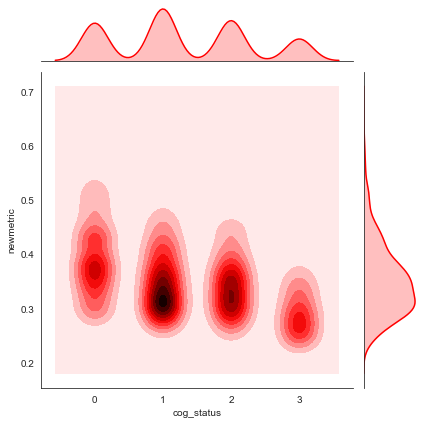

In [512]:
sns.jointplot(x='cog_status',y='newmetric',data=messages,color='red',kind='kde');
messages.groupby('cog_status')['newmetric'].mean()

In [435]:
messages['newmetric'].describe()

count    1102.000000
mean        0.351705
std         0.067508
min         0.229081
25%         0.302704
50%         0.341843
75%         0.387968
max         0.661113
Name: newmetric, dtype: float64

### Classification method with random forests
I tried several classifiers (feed-forward neural networks, SVN classifiers, multinomial logistic regressions...) and Random forest classifiers were the best prediction model. Instead of fitting them with the calculated new metric, I trained the model with the four parameters individually so the random forest model assigned weights internally in the clasification criteria and used it on the validation data. 

Accuracy values were around 90% (however that accuracy is not real, see explanation below) after 10-fold cross validation when using those four features:

- Matches with the top words (N=28) for that clip
- Number of words not mentioned in any of the descriptions for that clip
- Length of the description
- Averaged speech rate

Training with 70% of the data, validating with 30%

In [440]:
features = messages[ ['count','lentext','countneg', 'SpeechRateAvg']]

target = messages['cog_status']    

# Training with 70% of the data, validating with 30%
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
features.describe()
target.describe()
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rfc_preds = rfc.predict(X_test)
print(classification_report(y_test,rfc_preds))
print('MAE:', metrics.mean_absolute_error(y_test, rfc_preds))
print('MSE:', metrics.mean_squared_error(y_test, rfc_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,rfc_preds)))

# Printing confusion matrix
print(confusion_matrix(y_test,rfc_preds))
print('Test accuracy is {}'.format(accuracy_score(y_test, rfc_preds)))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        81
           1       0.92      0.91      0.91       118
           2       0.90      0.89      0.90        83
           3       0.88      0.90      0.89        49

    accuracy                           0.91       331
   macro avg       0.91      0.91      0.91       331
weighted avg       0.91      0.91      0.91       331

MAE: 0.11782477341389729
MSE: 0.1782477341389728
RMSE: 0.42219395322407544
[[ 76   3   1   1]
 [  5 107   3   3]
 [  2   5  74   2]
 [  0   1   4  44]]
Test accuracy is 0.9093655589123867


Running a cross-validation of 10

In [445]:
accuracy = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
    features.describe()
    target.describe()
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(X_train,y_train)
    rfc_preds = rfc.predict(X_test)
    accuracy.append(accuracy_score(y_test, rfc_preds))

print(accuracy, '\n', 'The average accuracy is ', np.mean(accuracy))

[0.8942598187311178, 0.9123867069486404, 0.8912386706948641, 0.9244712990936556, 0.9244712990936556, 0.8580060422960725, 0.8942598187311178, 0.9003021148036254, 0.9093655589123867, 0.9395770392749244] 
 The average accuracy is  0.904833836858006


Replacing a feature with its average in the model ramps the accuracy to >95% most of the time. For example, see the replacement of length of text with 'average number of words' below. Using the average of features really benefits the model with Random Forest classifiers. This does not happen with other models (SVN, neural networks, regressions...). 

In [515]:
features = messages[ ['count','avgUnique','countneg','SpeechRateAvg']]

accuracy = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
    features.describe()
    target.describe()
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(X_train,y_train)
    rfc_preds = rfc.predict(X_test)
    accuracy.append(accuracy_score(y_test, rfc_preds))

print(accuracy, '\n', 'The average accuracy is ', np.mean(accuracy))

[1.0, 1.0, 1.0, 0.9969788519637462, 1.0, 1.0, 1.0, 0.9969788519637462, 1.0, 1.0] 
 The average accuracy is  0.9993957703927492


What I am finding is not a real prediction but something different, overfitting. If we use the average for a feature, we lose variability and there are fewer values to train. Because I am shuffling the data so same subjects provide data both in the training and validation sets, it is easier for the model to gets overfitted and perform that well because average values appear exactly again in the dataset for data from the same subject. I repeated the validation with a set with different participants and confirmed that this is the case - accuracy values drop if I do not use averaged values so I still need to work on the prediction model using other strategies. At least this model would perform better than IA scores in terms of correlation.

In the code below I am working the way to plot accuracy with ROC curves applied to multiclasses model, just for future reference.

### ROC Curves
ROC curves only work in binary classification problems. I need to binarize labels in a one-vs-all fashion first. I will plot the confusion matrixes for each class and plot them separately and on average. In the end classes 1 and 4 (normal and dementia) had the better accuracy values and area under the curve values

Class:  0
[[245   5]
 [  3  78]]
Test accuracy is 0.9758308157099698
Class:  1
[[211   8]
 [ 17  95]]
Test accuracy is 0.9244712990936556
Class:  2
[[243   1]
 [ 20  67]]
Test accuracy is 0.9365558912386707
Class:  3
[[279   1]
 [  5  46]]
Test accuracy is 0.9818731117824774
ROC curve of class 0 (area = 0.97)
ROC curve of class 1 (area = 0.91)
ROC curve of class 2 (area = 0.88)
ROC curve of class 3 (area = 0.95)


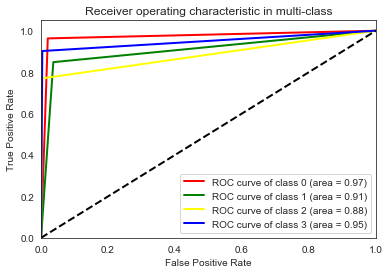

In [389]:
mean_accuracy = []
frprs = []
tprs = []
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
features = messages[ ['count','lentext','countneg', 'SpeechRateAvg']]
target = messages['cog_status']    
target = label_binarize(target, classes=[0,1,2,3])

for j in range(1):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(X_train,y_train)
    rfc_preds = rfc.predict(X_test)   
  
    for i in range(n_classes):
        print('Class: ', i)
        print(confusion_matrix(y_test[:,i],rfc_preds[:,i]))
        print('Test accuracy is {}'.format(accuracy_score(y_test[:,i], rfc_preds[:,i])))
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], rfc_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(4):
    print('ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic in multi-class')
plt.legend(loc="lower right")
plt.show()    

### Decision tree visualization

The plot below shows the decision criteria in every tree of the model, starting from the top and using one parameter at a time, the model is able to classify every entry into one of the four cognitive level categories in different colors

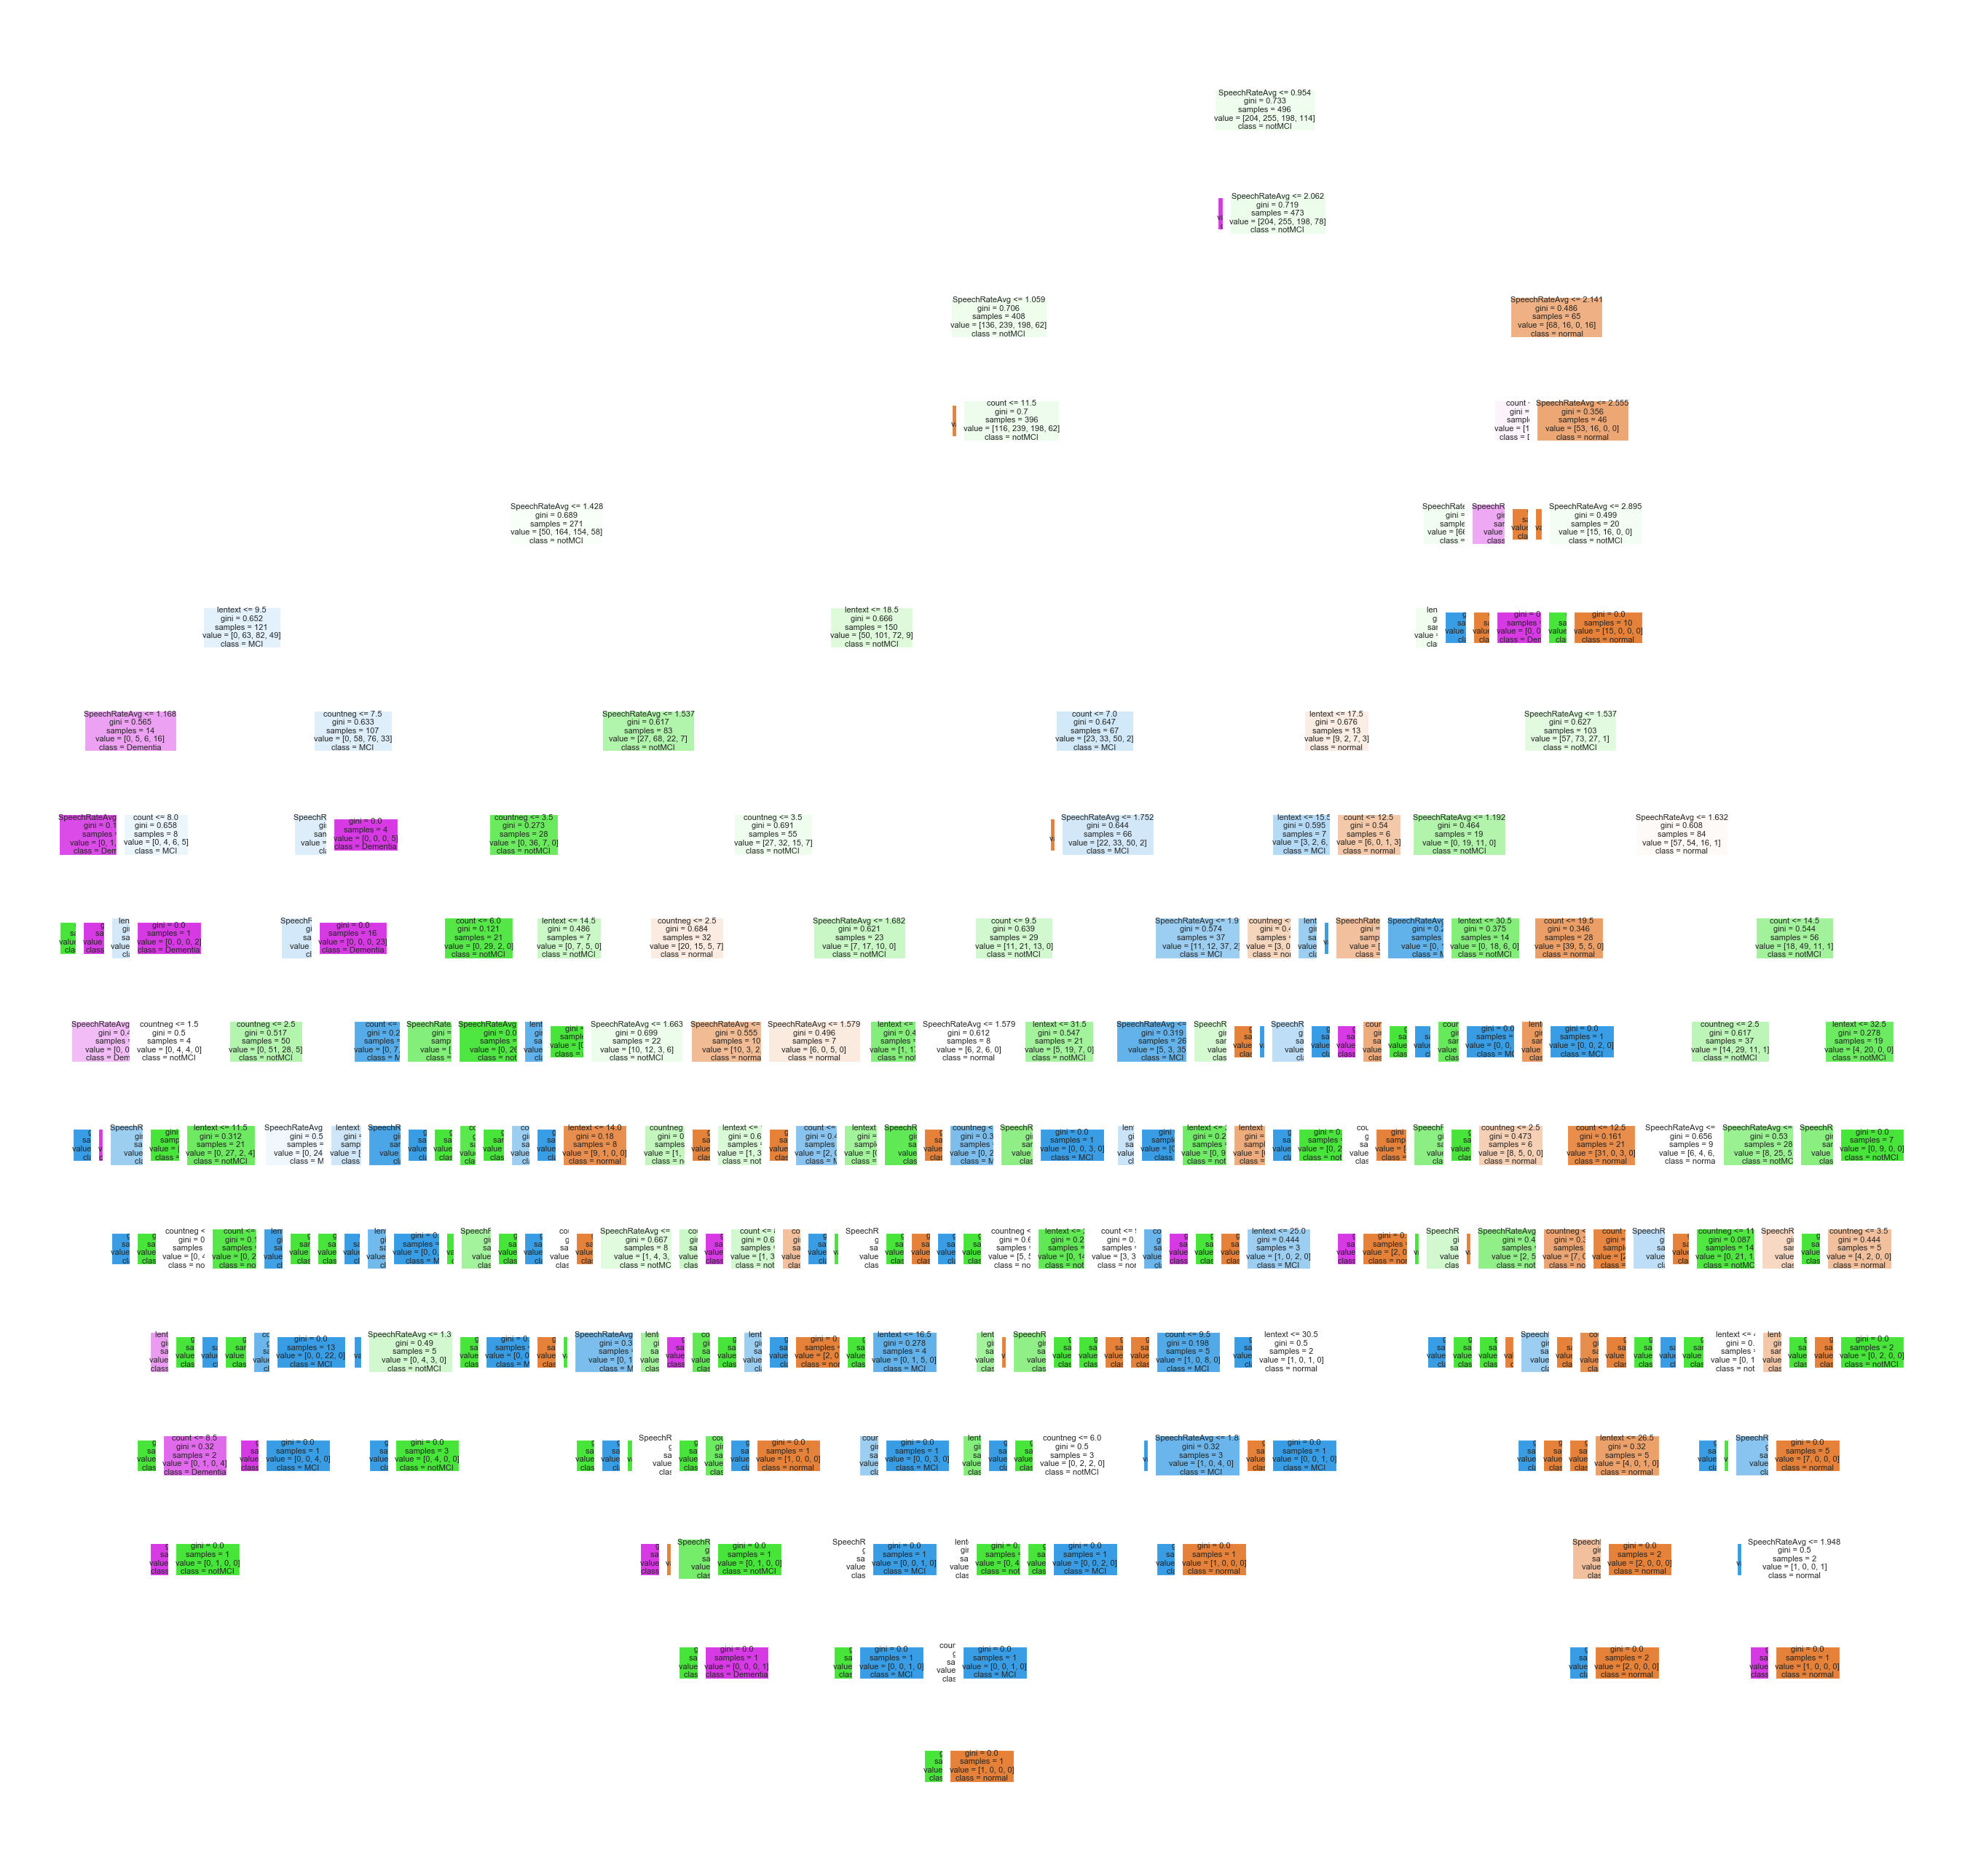

In [367]:
features_names = ['count','lentext','countneg', 'SpeechRateAvg']
class_names = ['normal','notMCI','MCI', 'Dementia']
estimator = rfc.estimators_[5]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc.estimators_[0],
               feature_names = features_names, 
               class_names=class_names,
               filled = True);
fig.savefig('rf_individualtree.png')